## Installing and Importing some necessary modules

In [1]:
# !pip install catboost
# !pip install kaggle
# !pip install pyarrow

In [2]:
# Libraries
import os.path

import numpy as np
import pandas as pd
import random
import gc, os

from datetime import timedelta 
from datetime import datetime

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler

from catboost import CatBoostClassifier, Pool

import matplotlib.pyplot as plt

%matplotlib inline

pd.options.display.max_columns = None
pd.options.display.max_rows = None

## Seeding all random parameters for reproducibility

In [3]:
# Random seed
SEED = 123

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(SEED)

## Downloading and Reading the dataset

In [4]:
# os.environ['KAGGLE_CONFIG_DIR'] = '/notebooks/'
# !kaggle datasets download -d abhimanyukarshni/riiid-train

In [5]:
# !unzip riiid-train.zip
# !rm riiid-train.zip

In [6]:
# import data
train = pd.read_feather("riiid_train1.feather").iloc[:22000000].reset_index(drop = True)
val = pd.read_feather("riiid_train1.feather").iloc[22000000:].reset_index(drop = True)

Splitting training dataset into train and validation sets. Then extracting meaningful features for training

In [7]:
TARGET = 'answered_correctly'
# Features to train and predict
FEATURES = ['prior_question_elapsed_time',
       'prior_question_had_explanation', 'answered_correctly_u_avg',
       'explanation_u_avg', 'part', 'answered_correctly_q_avg', 'explanation_q_avg','elapsed_time_q',
       'timestamp_u_recency_1', 'timestamp_u_recency_2',
       'timestamp_u_recency_3', 'timestamp_u_incorrect_recency',
       'num_questions_u', 'num_correct_u', 'num_lectures',
       'num_explanations_u', 'num_0', 'num_1', 'num_2', 'num_3',
       'num_questions_q', 'num_correct_q', 'num_explanations_q', 'community',
       'type_0', 'type_1', 'type_2', 'type_3']

# Shuffle
train = train.sample(22000000, random_state = SEED)
gc.collect()

drop_cols = list(set(train.columns) - set(FEATURES))
y_train = train[TARGET]
y_val = val[TARGET]
# Drop unnecessary columns
train.drop(drop_cols, axis = 1, inplace = True)
val.drop(drop_cols, axis = 1, inplace = True)
gc.collect()

14

# CatBoost Algorithm

Assigning categorical feature indices which are **part** and **community**

In [8]:
categorical_features_indices = [4, 23]

Creating CatBoostClassifier model with some parameters and training it with data which was processed above

In [9]:
 model = CatBoostClassifier(
        cat_features = categorical_features_indices,
        loss_function='Logloss',
        eval_metric='AUC',    
        iterations = 1000,
        random_seed = SEED,
        use_best_model = True,
        task_type = "GPU",
        nan_mode='Min',
        verbose=100
    )

In [10]:
model.fit(
        train, y_train,
        verbose_eval=100, 
        early_stopping_rounds=100,
        cat_features=categorical_features_indices,
        eval_set=(val, y_val),
        use_best_model=True,
)

Learning rate set to 0.030438
0:	learn: 0.5585870	test: 0.5580057	best: 0.5580057 (0)	total: 1.71s	remaining: 28m 26s
100:	learn: 0.7330384	test: 0.7342485	best: 0.7342485 (100)	total: 3m 27s	remaining: 30m 45s
200:	learn: 0.7458516	test: 0.7474291	best: 0.7474291 (200)	total: 7m	remaining: 27m 51s
300:	learn: 0.7505841	test: 0.7519575	best: 0.7519575 (300)	total: 10m 47s	remaining: 25m 4s
400:	learn: 0.7532762	test: 0.7544328	best: 0.7544328 (400)	total: 14m 39s	remaining: 21m 53s
500:	learn: 0.7552678	test: 0.7562909	best: 0.7562909 (500)	total: 18m 34s	remaining: 18m 29s
600:	learn: 0.7565375	test: 0.7574875	best: 0.7574875 (600)	total: 22m 28s	remaining: 14m 55s
700:	learn: 0.7575938	test: 0.7584602	best: 0.7584602 (700)	total: 26m 28s	remaining: 11m 17s
800:	learn: 0.7584316	test: 0.7592190	best: 0.7592190 (800)	total: 30m 27s	remaining: 7m 34s
900:	learn: 0.7591287	test: 0.7598552	best: 0.7598552 (900)	total: 34m 29s	remaining: 3m 47s
999:	learn: 0.7597814	test: 0.7604468	best: 0

In [11]:
model.save_model('storage/cat_20M',
           format="cbm")

In [12]:
# model.load_model('cat_30M', format = "cbm")

As the data is too big for iterating through it at once, I only considered a fraction (5 million) samples to calculate feature importance

In [13]:
X = train.iloc[:5000000]
y = y_train.iloc[:5000000]
del train, y_train, val, y_val

In [14]:
feature_score = pd.DataFrame(list(zip(X.dtypes.index, model.get_feature_importance(Pool(X, label=y, cat_features=categorical_features_indices)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

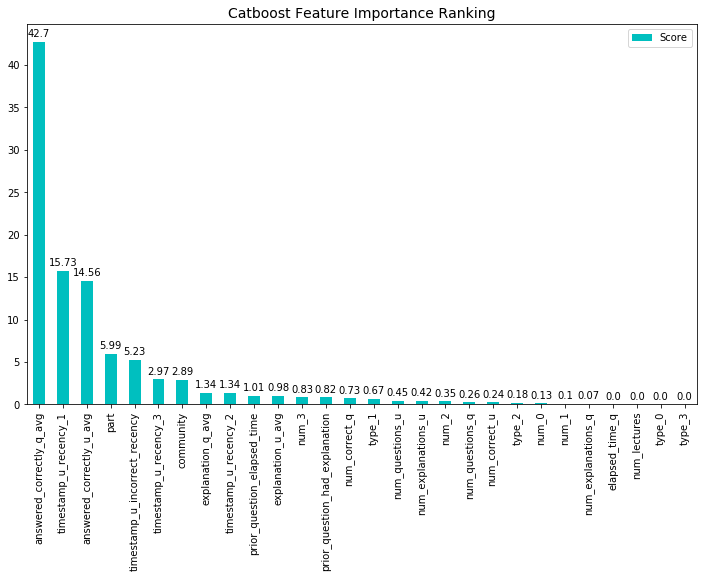

In [15]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()